# A Simple Multiple Choice Question Answering Task

We will walk through an example of causal abstraction analysis on trivial multiple-choice questions.

In each question, we ask simply state the color of an object and then ask what color that object is (originally from [Wiegreffe et al. 2024](https://arxiv.org/abs/2407.15018)). For example:

The cauliflower is white. What color is the cauliflower?

A. yellow

B. white

Answer: N



In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../..")
from tasks.MCQA.mcqa import MCQA_task, sample_answerable_question
import random
random.seed(42)

nnsight is not detected. Please install via 'pip install nnsight' for nnsight backend.



# A Causal Model for MCQA with a Positional Variable

A causal model is a directed graph of **variables** that each have a **mechanism** that determines the variables **value** based on the values of its parents. 


The causal model we load below creates a simple multiple choice question answering (MCQA) dataset where world knowledge about the color of an object is stated and then the color of that object is asked about. We have input variables for the answer choices and the symbol associated with each choice, an object/color pair, and a template for embedding the object, color, choices, and symbols into a well-formed multiple choice question. 

The crux of the model is the intermediary variable with a mechanism that determines the position of the correct choice, which feeds into the output variable with a mechanism that uses the positional information select the right answer. 

Finally, every causal model in this code base is required to have two particular variables: 
- "raw_input" is the variable with a value that can be plugged into a neural network via Pipeline.load().
- "raw_output" is the variable with a value that can be compared with Pipeline.dump(), the neural network output.

In this setting, raw_input variable uses the template to form an LM query and the raw_output is simply a direct copy of the answer.

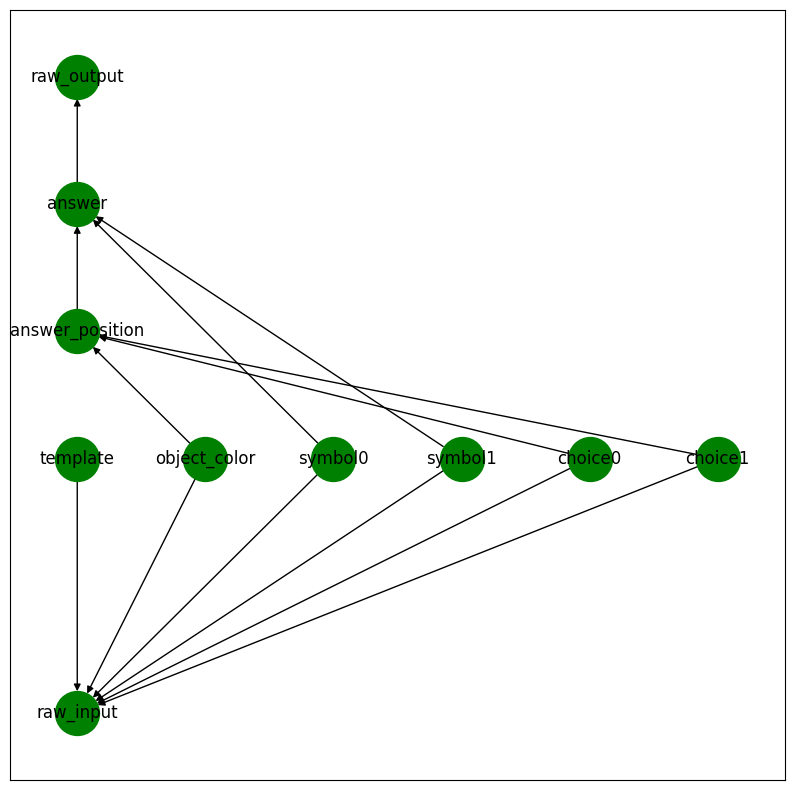

In [2]:
causal_model = MCQA_task.causal_models["positional"]

causal_model.print_structure()


Causal model inputs are dictionaries from **input** variable to values.

In [3]:
example = sample_answerable_question()
print("Example input:")
for k, v in example.items():
    print(f"{k}:\n \"{v}\"\n")

Example input:
template:
 "The <object> is <color>. What color is the <object>?
<symbol0>. <choice0>
<symbol1>. <choice1>
Answer:"

object_color:
 "('banana', 'yellow')"

symbol0:
 "J"

symbol1:
 "D"

choice0:
 "red"

choice1:
 "yellow"



When we run a causal model on an input, the result is a dictionary mapping from **all** variables to values. Below we print out the only non-input variables:

In [4]:
full_setting = causal_model.run_forward(example)
print("\nFull setting determined by the causal model:")
for k, v in full_setting.items():
    if k not in example:
        print(f"{k}:\n \"{v}\"\n")


Full setting determined by the causal model:
answer_position:
 "1"

answer:
 "D"

raw_input:
 "The banana is yellow. What color is the banana?
J. red
D. yellow
Answer:"

raw_output:
 " D"



We can perform an intervention on the causal model that fixes the value of a variable. For example, we can fix the answer pos